# Test for the normality of the data

cheching the normality of the distance between the the municipalities


In [8]:
test_name = "testing normality"
sample_fraq = 1
randomSeed = 11


In [9]:
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopy.distance

# Plotting modules
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.basemap import Basemap

# ======= NORMALITY TESTS ======= #
# D'Agostino's K^2 Test
from scipy.stats import normaltest

# Jarque-Bera Test
from scipy.stats import jarque_bera

# Anderson-Darling Test
from scipy.stats import anderson

# Cramer-von Mises Criterion
from scipy.stats import cramervonmises

# Kolmogorov-Smirnov Test
from scipy.stats import kstest

# Liliefors Test
from statsmodels.stats.diagnostic import lilliefors

# Shapiro-Wilk Test
from scipy.stats import shapiro

# Pearson's chi-squared test
from scipy.stats import chisquare

# QQ Plot
from statsmodels.graphics.gofplots import qqplot

# PP Plot
from scipy.stats import probplot

# ======= NORMALITY TESTS ======= #

# ======= HOMOGENEITY TESTS ======= #
# Pettitt test (pettitt_test)
# Standard Normal Homogeinity Test (SNHT) Test (snht_test)
# Buishand Q Test (buishand_q_test)
# Buishand's Range Test (buishand_range_test):
# Buishand's Likelihood Ration Test (buishand_likelihood_ratio_test)
# Buishand U Test (buishand_u_test)
from pyhomogeneity import (
    pettitt_test,
    snht_test,
    buishand_q_test,
    buishand_range_test,
    buishand_likelihood_ratio_test,
    buishand_u_test,
)
from distfit import distfit


## Load the data

In [10]:
# import the data and parameters and check the data

data_path = "data/"
start_time = time.time()
# ====Parameters==== #
parameters = pd.read_csv(os.path.join(data_path, "parametros.csv"))
# 1. food_per_person_per_day in tons per day
food_per_person_per_day = float(
    parameters.loc[parameters["parametro"] == "comida_por_persona_en_toneladas"].values[
        0
    ][1]
)
# 2. transport_cost_per_ton_per_km in COP per ton per km
transport_cost_per_ton_per_km = float(
    parameters.loc[
        parameters["parametro"] == "costo_de_transporte_por_tonelada_por_kilomentro"
    ].values[0][1]
)

print(
    f"parameters: \n    food_per_person_per_day: {food_per_person_per_day} \n    transport_cost_per_ton_per_km: {transport_cost_per_ton_per_km}\n"
)
# ====Parameters==== #

# ====importData==== #
# 1. population, from data/municipios_procesado.csv
population = pd.read_csv(
    os.path.join(data_path, "municipios_procesado.csv"), index_col=3
)
# 2. distance, from data/distance_matrix_final.csv
distance = pd.read_csv(
    os.path.join(data_path, "distance_matrix_final.csv"), index_col=0
)
# 3. warehouses, from data/almacenes.csv
warehouses = pd.read_csv(os.path.join(data_path, "almacenes.csv"))
# ====importData==== #

# ====DataProcessing===== #
# fill the nan values in population with the minimum '2024' from the departamento of Chocó for the columns 22:
population.loc[population.isna().any(axis=1), population.columns[18:]] = (
    population[
        population["2024"]
        == population.loc[population["departamento"] == "Chocó"]["2024"].min()
    ]
    .iloc[0, 18:]
    .values
)
# drop the municipalities with nan values in the first column of the distance matrix
distance = distance.dropna(subset=[distance.columns[0]], axis=0)
distance = distance.dropna(subset=[distance.index[0]], axis=1)
# turn the columns of distance into integers
distance.columns = distance.columns.astype(int)
# Take a sample of the data
distance = distance.sample(frac=sample_fraq, random_state=randomSeed)
distance = distance.loc[
    :, distance.index
]  # make the distance matrix symmetric # type: ignore
# if there is a 0 value that is not in the diagonal, replace it with the mean of the column
zeros_count = 0
for i in distance.index:
    for j in distance.columns:
        if distance.loc[i, j] == 0 and i != j:
            distance.loc[i, j] = np.nan
            zeros_count += 1
# Drop the nan values
distance = distance.dropna()
# make the distance matrix symmetric
distance = distance.loc[:, distance.index]
# turn distance to km
distance = distance / 1000
# select only the rows in population dpmp that the index is in distance
population = population.loc[distance.index]
# Check if every value of distance is larger than the linear distance for every pair of municipalities in population lat and lon are in the population dataframe
larger_than_linear_distance_count = 0
for i in distance.index:
    for j in distance.columns:
        if i != j:
            # get the linear distance
            linear_distance = geopy.distance.distance(
                (population.loc[i, "lat"], population.loc[i, "lon"]),
                (population.loc[j, "lat"], population.loc[j, "lon"]),
            ).km
            # check if the linear distance is larger than the distance in the distance matrix
            if linear_distance > distance.loc[i, j]:
                distance.loc[i, j] = linear_distance
                larger_than_linear_distance_count += 1
# Check if there are any nan values in distance
if distance.isna().any().any():
    print("There are nan values in the distance matrix")
print(
    f"data information: \n    population: {population.shape} \n    distance: {distance.shape} \n    warehouses: \n {warehouses} \n"
)
# ====DataProcessing===== #

# ====DataInformation==== #
# Memory usage of the data
print(f"population memory usage: {population.memory_usage().sum()/1024**2:.2f} MB")  # type: ignore
print(f"distance memory usage: {distance.memory_usage().sum()/1024**2:.2f} MB")  # type: ignore
print(f"warehouses memory usage: {warehouses.memory_usage().sum()/1024**2:.2f} MB")  # type: ignore
# ====DataInformation==== #

# ====DataChecking==== #
# Test to the data if needed
# ====DataChecking==== #
print(f"Elapsed time: {time.time() - start_time:.2f} s")
print(
    f"Amount of zeros in the distance matrix: {zeros_count}, %error: {zeros_count/(distance.shape[0]*distance.shape[1])*100:.2f}"
)
print(
    f"Amount of distances that were smaller than the linear distance: {larger_than_linear_distance_count}, %error: {larger_than_linear_distance_count/(distance.shape[0]*distance.shape[1])*100:.2f}"
)


parameters: 
    food_per_person_per_day: 0.00087617 
    transport_cost_per_ton_per_km: 3364.0

data information: 
    population: (1089, 71) 
    distance: (1089, 1089) 
    warehouses: 
    Type  capacity_ton        cost
0     1          1074  3111202.75
1     2          2418  4804980.75 

population memory usage: 0.63 MB
distance memory usage: 9.09 MB
warehouses memory usage: 0.00 MB
Elapsed time: 343.93 s
Amount of zeros in the distance matrix: 40, %error: 0.00
Amount of distances that were smaller than the linear distance: 930, %error: 0.08


## Distance Matrix

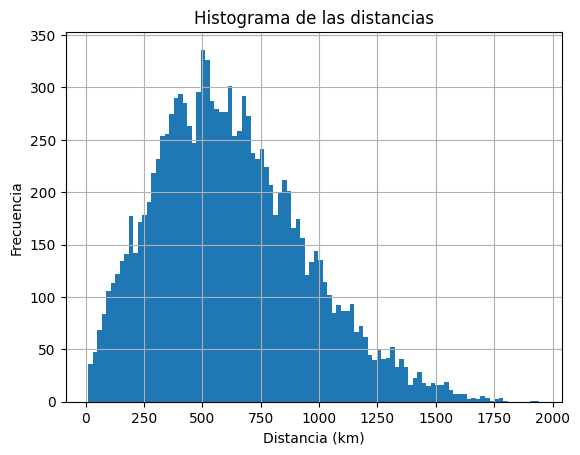

Shapiro-Wilk Test
stat: 0.98, p: 6.297680401305231e-40
D'Agostino's K^2 Test
stat: 549.73, p: 4.2354934589350676e-120
Jarque-Bera Test
stat: 626.77, p: 7.930187879822297e-137
Anderson-Darling Test
stat: 57.61, p: [0.576 0.656 0.787 0.918 1.092]
Kolmogorov-Smirnov Test
stat: 1.00, p: 0.0
Liliefors Test
stat: 0.05, p: 0.0009999999999998899


(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'Distribución de las distancias con respecto a la distribución normal\nnorm(loc=623.353, scale=320.477)'}, xlabel='distancia (km)', ylabel='Frecuencia acumulada'>)

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,norm,0.000001,623.352898,320.476602,(),"(623.3528984684684, 320.47660167996395)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c


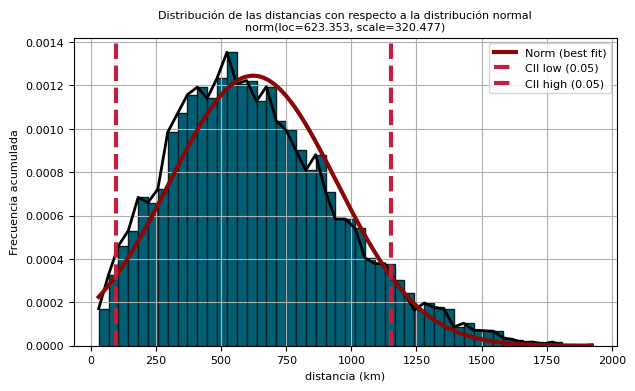

In [4]:
flatten_distance = []
for i in distance.index:
    for j in distance.columns:
        if i != j:
            flatten_distance.append(distance.loc[i, j])
flatten_distance = np.array(flatten_distance)
flatten_distance = flatten_distance[flatten_distance < 2500]
# Histogram of the distances
%matplotlib inline
plt.hist(flatten_distance, bins=100)
plt.title("Histograma de las distancias")
plt.xlabel("Distancia (km)")
plt.ylabel("Frecuencia")
plt.grid()
# size small
plt.rcParams.update({"font.size": 8})
# Size of the plot small
plt.rcParams["figure.figsize"] = (5, 1)
plt.show()

# Normality tests
# Shapiro-Wilk Test
stat, p = shapiro(flatten_distance)
print("Shapiro-Wilk Test")
print(f"stat: {stat:.2f}, p: {p}")
# D'Agostino's K^2 Test
stat, p = normaltest(flatten_distance)
print("D'Agostino's K^2 Test")
print(f"stat: {stat:.2f}, p: {p}")
# Jarque-Bera Test
stat, p = jarque_bera(flatten_distance)
print("Jarque-Bera Test")
print(f"stat: {stat:.2f}, p: {p}")
# Anderson-Darling Test
result = anderson(flatten_distance)
print("Anderson-Darling Test")
print(f"stat: {result.statistic:.2f}, p: {result.critical_values}")
# Kolmogorov-Smirnov Test
stat, p = kstest(flatten_distance, "norm")
print("Kolmogorov-Smirnov Test")
print(f"stat: {stat:.2f}, p: {p}")
# Liliefors Test
stat, p = lilliefors(flatten_distance)
print("Liliefors Test")
print(f"stat: {stat:.2f}, p: {p}")
dist = distfit(verbose=0, distr = "norm")
dist.fit_transform(flatten_distance)
display(
    dist.plot(
        n_top=5,
        figsize=(7, 4),
        fontsize=8,
        title="Distribución de las distancias con respecto a la distribución normal",
        chart= "pdf",
        xlabel="distancia (km)",
        ylabel="Frecuencia acumulada",
        emp_properties={ 'color': '#000000','linewidth': 2,'linestyle': '-' },
        bar_properties={ 'color': '#025E73','linewidth': 1,'edgecolor': '#011F26','align': 'edge' },
    )
)
display(dist.summary)


In [7]:
flatten_distance = pd.Series(flatten_distance)

# Pruebas de petitt test
h, cp, p, U, avg = pettitt_test(flatten_distance)
print(f"pettitt test: {h, cp, p, U, avg}")
# Pruebas de snht test
h, cp, p, U, avg = snht_test(flatten_distance)
print(f"snht test: {h, cp, p, U, avg}")
# Pruebas de buishand_q_test
h, cp, p, U, avg = buishand_q_test(flatten_distance)
print(f"buishand_q_test: {h, cp, p, U, avg}")
# Pruebas de buishand_range_test
h, cp, p, U, avg = buishand_range_test(flatten_distance)
print(f"buishand_range_test: {h, cp, p, U, avg}")
# Pruebas de buishand_likelihood_ratio_test
h, cp, p, U, avg = buishand_likelihood_ratio_test(flatten_distance)
print(f"buishand_likelihood_ratio_test: {h, cp, p, U, avg}")
# Pruebas de buishand_u_test
h, cp, p, U, avg = buishand_u_test(flatten_distance)
print(f"buishand_u_test: {h, cp, p, U, avg}")
# Pruebas de independencia


pettitt test: (True, 5936, 0.0, 4592504.0, mean(mu1=661.3106703504043, mu2=587.4400304590373))
snht test: (True, 5934, 0.0, 162.08660475648657, mean(mu1=661.327877165487, mu2=587.4473019757808))
buishand_q_test: (True, 5934, 0.0, 6.363424887848298, mean(mu1=661.327877165487, mu2=587.4473019757808))
buishand_range_test: (True, 5934, 0.0, 6.3998709153677575, mean(mu1=661.327877165487, mu2=587.4473019757808))
buishand_likelihood_ratio_test: (True, 5934, 0.0, 0.11522149760100195, mean(mu1=661.327877165487, mu2=587.4473019757808))
buishand_u_test: (True, 5934, 0.0, 9.242935226580958, mean(mu1=661.327877165487, mu2=587.4473019757808))
